Algorithm to transform document to embedding is SBERT
Approach: SBERT transforms sentences to fixed size embedding
Data = L90 

Source: 

https://medium.com/analytics-vidhya/best-nlp-algorithms-to-get-document-similarity-a5559244b23b


https://www.sbert.net/examples/applications/computing-embeddings/README.html



In [1]:
! pip install transformers sentence_transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 895 kB 59.4 MB/s 
     |████████████████████████████████| 6.6 MB 39.0 MB/s 
     |████████████████████████████████| 596 kB 59.9 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=879f871b0b8d76b5a0316cd13d8abd218e95c1a9060b4be40ca4932e5c2a4d48
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###0. Text preprocessing (Maybe not needed): 

* Normalization: transforming the text into lower case and removing all the special characters and punctuations.

* Tokenization: getting the normalized text and splitting it into a list of tokens.

* Removing stop words: stop words are the words that are most commonly used in a language and do not add much meaning to the text. Some examples are the words ‘the’, ‘a’, ‘will’,…

* Stemming: it is the process to get the root of the words and sometimes this root is not equal to the morphological root of the word, but the stemming goal is to make that related word maps to the same stem. Examples: branched and branching become branch.

* Lemmatization: This is the process of getting the same word for a group of inflected word forms, the simplest way to do this is with a dictionary. Examples: is, was, were become be.

In [2]:
!pip install stanza
import stanza
print("Downloading English model...")
stanza.download('en')

import glob
import nltk
import ssl
print("Downloading stop words...")
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
from nltk.corpus import stopwords

# getting stopwords
stop_words_english = stopwords.words('english')

def tokenize_and_normalize(doc_raw, stopwords):
    """Tokenizes, lemmatizes, lowercases and removes stop words.
    
    this function takes in a path to a doc, reads the doc file,
    tokenizes it into words, then lemmatizes and lowercases these words.
    finally, stopwords given to the function are removed from the list of doc lemmas
    
    Parameters
    ----------
    doc_raw : str
    stopwords : list of strings
        stopwords that should be removed
    
    Returns
    -------
    normalized_song : list of strings
        a doc represented as a list of its lemmas
    """
    nlp = stanza.Pipeline(lang='en', processors='tokenize, lemma',  verbose=False)
    
    # YOUR CODE HERE
    
    doc=nlp(doc_raw)
    words = doc.iter_words()
    normalized_doc = []
    for w in words:
        w = w.lemma.lower()
        if not w in stopwords:
            normalized_doc.append(w)
    normalized_doc = ' '.join(normalized_doc)
    return normalized_doc

     |████████████████████████████████| 574 kB 5.1 MB/s 
     |████████████████████████████████| 175 kB 65.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=71cd81ddad7901051be3934699dc69c2b337a3b05c27858f70a5207653d58775
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


2022-04-27 19:58:58 INFO: Downloading default packages for language: en (English)...


2022-04-27 19:59:50 INFO: Finished downloading models and saved to /root/stanza_resources.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###1. Load dataset

In [3]:
import os
import re
## Load dataset into a list of sentences
# os.mkdir("Data")

## Remove the numbers at the start and end of the documents.
DATAFILE = "/content/drive/MyDrive/LeePincombeWelshDocuments.txt"
CLEANFILE = "./Data/cleanLPW.txt"
INDIVIDUAL_DOCS = "./Data/"

if (os.path.exists(CLEANFILE)):
    os.remove(CLEANFILE)
i = 0
DATADICT = {}
with open(DATAFILE, 'r', encoding="utf8", errors="ignore") as inputfile:
     lines = inputfile.readlines()
     for line in lines:
        start_removed = re.sub("(\d*\.\s)", "", line)
        end_removed = re.sub("\(\d* words\)", ".", start_removed)
        normalized_doc = tokenize_and_normalize(end_removed, stop_words_english)
        DATADICT[i] = normalized_doc
        with open(INDIVIDUAL_DOCS+f"/{i}.txt", "w+") as docfile:
            docfile.write(end_removed)
            i = i + 1
DATADICT.pop(0)
DATADICT.pop(51)
print(DATADICT)

{1: "national executive strife - tear democrat last night appoint little - know west australian senator brian greig interim leader - shock move likely provoke conflict party 's senator organisation move reassert control party 's seven senator , national executive last night reject aden ridgeway 's bid become interim leader , favour senator greig , supporter depose leader natasha stott despoja outspoken gay rights activist .", 2: 'cash - strapped financial service group amp shelved $ 400 million plan buy share back investor raise $ 750 million fresh capital profit crashed six month june chief executive paul batchelor say result " solid " describe bad condition stock market 20 yearsamp \'s half - year profit sink 25 per cent $ 303 million , 27 c share , australia \'s large investor fund manager fail hit project 5 per cent earnings growth target batter fall return share market .', 3: 'united state government say want see president robert mugabe remove power work zimbabwean opposition brin

In [4]:
l = []
ls = list(DATADICT.values())
for i in range(len(ls)):
  if len(ls[i]) > 256:
    l.append(len(ls[i]))
len(l)

45

###2. Load SBERT for embedding sentences


In [5]:
from sentence_transformers import SentenceTransformer
import pickle

model_names = ['all-mpnet-base-v2', 'all-distilroberta-v1', 'all-MiniLM-L12-v2', 'all-MiniLM-L6-v2']
sentences = list(DATADICT.values())

def get_embedding(model_name, sentences):
  model = SentenceTransformer(model_name)
  embeddings = model.encode(sentences)
  #Store sentences & embeddings on disc
  path = os.path.join("Data/", model_name + ".pkl")
  with open(path, "wb") as fOut:
      pickle.dump({'sentences': sentences, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
for mn in model_names:
  get_embedding(mn, sentences)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [7]:
# embeddings.shape
# #Store sentences & embeddings on disc
# with open('Data/embeddings.pkl', "wb") as fOut:
#     pickle.dump({'sentences': sentences, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
#Load sentences & embeddings from disc
import pickle
from sentence_transformers import util
embed_dic = {}
def build_embedding_dic(model_name):
  path = os.path.join("Data/", model_name + ".pkl") 
  with open(path, "rb") as fIn:
      stored_data = pickle.load(fIn)
      stored_sentences = stored_data['sentences']
      stored_embeddings = stored_data['embeddings']
  print(type(stored_sentences), type(stored_embeddings))
  return stored_embeddings
 
for mn in model_names:
  embed_dic[mn] = build_embedding_dic(mn)


## TO DO test embedding of 1 sentence is fix???? Seems to changes

<class 'list'> <class 'numpy.ndarray'>
<class 'list'> <class 'numpy.ndarray'>
<class 'list'> <class 'numpy.ndarray'>
<class 'list'> <class 'numpy.ndarray'>


In [9]:
embed_dic

{'all-MiniLM-L12-v2': array([[-0.04930237,  0.00207158,  0.00108137, ..., -0.0758744 ,
          0.03496426,  0.05366564],
        [-0.00666703, -0.05666685, -0.07046464, ...,  0.01988467,
         -0.0113067 ,  0.01022982],
        [-0.11965793,  0.01674426, -0.04629659, ...,  0.08051261,
          0.01777139, -0.05208147],
        ...,
        [-0.04807492,  0.07710016,  0.03216618, ...,  0.03393974,
         -0.00281109,  0.00331666],
        [ 0.09198608,  0.06655791,  0.01656382, ..., -0.10770672,
         -0.02801371, -0.04640127],
        [-0.01717398,  0.06082408, -0.05169213, ...,  0.01020509,
          0.02284773,  0.01472744]], dtype=float32),
 'all-MiniLM-L6-v2': array([[-6.1508478e-03, -3.3421554e-02,  5.8162540e-02, ...,
         -1.1329998e-01,  5.9725545e-02, -5.2720485e-03],
        [ 1.5085483e-04, -1.6321378e-02,  3.7489720e-02, ...,
         -1.6116795e-01, -7.2833978e-02,  1.8281644e-02],
        [-1.0167746e-01,  5.0830584e-02,  2.3840578e-02, ...,
         -2.624

# *3*. Cosine Similarity


In [18]:
import pandas as pd
human_evaluation_data = pd.read_csv("Data/AverageSimilarities_fixed.csv")
human_evaluation_data.head(10)

,Document_1,Document_2,Similarity_avg,Similarity_avg_normalized,Similarity_word2vec,Similarity_doc2vec,Similarity_tf_idf,Similarities_SBERT
0,1,2,1.5,0.125,0.546141,0.299788,0.021084,0.226575
1,1,3,1.2,0.050,0.756276,0.422498,0.004666,0.249689
2,1,4,1.0,0.000,0.602858,0.309068,0.028945,0.231258
3,1,5,1.5,0.125,0.645505,0.359952,0.001599,0.160115
4,1,6,2.5,0.375,0.640220,0.396535,0.013378,0.189578
5,1,7,1.3,0.075,0.603097,0.274688,0.017224,0.098158
6,1,8,1.2,0.050,0.608954,0.393639,0.020166,0.179572
7,1,9,1.0,0.000,0.482402,0.226962,0.065105,0.107363
8,1,10,1.3,0.075,0.575403,0.320317,0.003985,0.054968
9,1,11,1.3,0.075,0.671883,0.368066,0.003457,0.203473


In [65]:
docs1 = human_evaluation_data['Document_1']
docs2 = human_evaluation_data['Document_2']

# Traverse the human reference df
for mn in model_names:
  stored_embeddings = embed_dic[mn]
  print(f'Model - {mn} has embed_dic of size: {stored_embeddings.shape}')
  sbert_similarities = []
  for i in range(len(human_evaluation_data)):
    d1 = stored_embeddings[docs1[i]-1]
    d2 = stored_embeddings[docs2[i]-1]
    score = util.cos_sim(d1, d2) # Runtime = 2s
    sbert_similarities.append(score)

  # Append sbert_cosines to df
  human_evaluation_data['Similarities_SBERT_'+mn] = sbert_similarities
  human_evaluation_data['Similarities_SBERT_'+mn] = human_evaluation_data['Similarities_SBERT_'+mn].astype(float)
new_df = human_evaluation_data

Model - all-mpnet-base-v2 has embed_dic of size: (50, 768)
Model - all-distilroberta-v1 has embed_dic of size: (50, 768)
Model - all-MiniLM-L12-v2 has embed_dic of size: (50, 384)
Model - all-MiniLM-L6-v2 has embed_dic of size: (50, 384)


In [66]:
#new_df
new_df = new_df.drop(['Similarities_SBERT'], axis=1)
new_df

,Document_1,Document_2,Similarity_avg,Similarity_avg_normalized,Similarity_word2vec,Similarity_doc2vec,Similarity_tf_idf,Similarities_SBERT_all-mpnet-base-v2,Similarities_SBERT_all-distilroberta-v1,Similarities_SBERT_all-MiniLM-L12-v2,Similarities_SBERT_all-MiniLM-L6-v2
0,1,2,1.5,0.125,0.546141,0.299788,0.021084,0.211276,0.194087,0.153692,0.226575
1,1,3,1.2,0.050,0.756276,0.422498,0.004666,0.235512,0.304032,0.362678,0.249689
2,1,4,1.0,0.000,0.602858,0.309068,0.028945,0.164045,0.140319,0.243372,0.231258
3,1,5,1.5,0.125,0.645505,0.359952,0.001599,0.119264,0.228679,0.246797,0.160115
4,1,6,2.5,0.375,0.640220,0.396535,0.013378,0.245882,0.224649,0.204867,0.189578
...,...,...,...,...,...,...,...,...,...,...,...
1220,47,49,1.1,0.025,0.613274,0.317716,0.013448,0.047741,0.120123,0.105323,0.076289
1221,47,50,1.2,0.050,0.598408,0.292509,0.000063,0.064202,0.071049,0.112117,0.026614
1222,48,49,1.1,0.025,0.607929,0.375184,0.001326,0.069644,0.041385,0.077041,0.112215
1223,48,50,1.5,0.125,0.709688,0.410916,0.015981,0.235730,0.245767,0.278858,0.182121


In [23]:
new_df.to_csv('/content/Data/AverageSimilarities_fixed.csv', index=False)

In [101]:
def find_distance(x,y):
  return np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(x, y)])) 
x=new_df.Similarity_avg; y=new_df['Similarities_SBERT_all-mpnet-base-v2']
print(np.mean(new_df.Similarity_avg_normalized))
print(np.mean(new_df.Similarity_word2vec))
print(np.mean(new_df.Similarity_doc2vec))
print(np.mean(new_df.Similarity_tf_idf))
print(find_distance(x, y))


0.1581314162028451
0.6190564467591828
0.3173061514934715
0.018494981012646055
56.216810019408875


# 4. Metrics


In [57]:
### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 
# From AverageSimilarities_fixed.csv, calculate the 
# Pearson coefficient & Euclidean distance 
# between the Similarity_avg_normalized
# and the cosine distance from different models
### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

new_df = pd.read_csv('/content/Data/AverageSimilarities_fixed.csv')
print(new_df)
# measure Euc distance
def find_distance(x,y):
  return np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(x, y)]))   

e_dis = pd.DataFrame()
coeff_arr = []
dist_arr = []
x = new_df[new_df.columns[3]]
ind = []
x = new_df[new_df.columns[3]]
for i in range(3, len(new_df.columns)):
    y = new_df[new_df.columns[i]]
    ind.append(new_df.columns[i])
    coeff_score = np.corrcoef(x, y)[0][1]
    coeff_arr.append(coeff_score)
    dist = find_distance(x, y)
    dist_arr.append(dist)
  
    print(f'{new_df.columns[i]} : {coeff_score} ; {dist}')
d = {"Model":ind,'Pearson Correlation Coefficient': coeff_arr, 'Euclidean distance':dist_arr}
metrics = pd.DataFrame(data=d)
metrics

      Document_1  Document_2  Similarity_avg  Similarity_avg_normalized  \
0              1           2             1.5                      0.125   
1              1           3             1.2                      0.050   
2              1           4             1.0                      0.000   
3              1           5             1.5                      0.125   
4              1           6             2.5                      0.375   
...          ...         ...             ...                        ...   
1220          47          49             1.1                      0.025   
1221          47          50             1.2                      0.050   
1222          48          49             1.1                      0.025   
1223          48          50             1.5                      0.125   
1224          49          50             1.8                      0.200   

      Similarity_word2vec  Similarity_tf_idf  \
0                0.546141           0.021084   
1  

,Model,Pearson Correlation Coefficient,Euclidean distance
0,Similarity_avg_normalized,1.000000,0.000000
1,Similarity_word2vec,0.611659,16.869880
2,Similarity_tf_idf,0.566756,7.473878
3,Similarities_SBERT_all-mpnet-base-v2,0.710998,4.349744
4,Similarities_SBERT_all-distilroberta-v1,0.755298,4.084282
5,Similarities_SBERT_all-MiniLM-L12-v2,0.654225,4.700415
6,Similarities_SBERT_all-MiniLM-L6-v2,0.659849,4.822105
7,Similarity_doc2vec_enwiki_dbow,0.625702,7.401984
8,Similarity_doc2vec_apnews_dbow,0.557340,5.416838


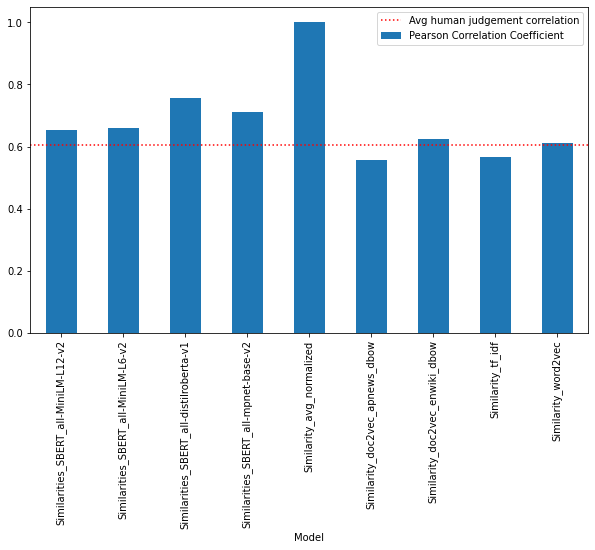

In [58]:
metrics.sort_values(by="Pearson Correlation Coefficient",inplace=True)

df_pivot = pd.pivot_table(
	metrics,
	values="Pearson Correlation Coefficient",
	index="Model",
)
# Plot a bar chart using the DF
ax = df_pivot.plot(kind="bar")
ref_line = ax.axhline(y=0.605, linestyle=':', color='r')
ref_line.set_label('Avg human judgement correlation')
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
ax.legend()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 6)


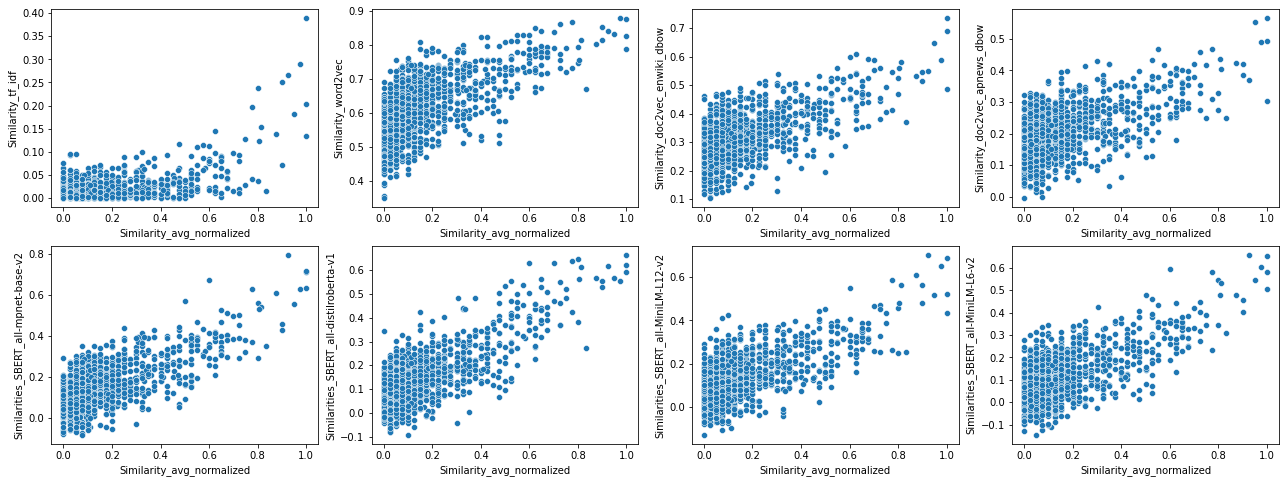

In [59]:
fig, axes = plt.subplots(2, 4, figsize=(22, 8))

sns.scatterplot(ax=axes[0, 0], x="Similarity_avg_normalized", y="Similarity_tf_idf", data=new_df);
sns.scatterplot(ax=axes[0, 1], x="Similarity_avg_normalized", y="Similarity_word2vec", data=new_df);
sns.scatterplot(ax=axes[0, 2], x="Similarity_avg_normalized", y="Similarity_doc2vec_enwiki_dbow", data=new_df);
sns.scatterplot(ax=axes[0, 3], x="Similarity_avg_normalized", y="Similarity_doc2vec_apnews_dbow", data=new_df); ## FOR NEW Doc2Vec model

sns.scatterplot(ax=axes[1, 0], x="Similarity_avg_normalized", y="Similarities_SBERT_all-mpnet-base-v2", data=new_df);
sns.scatterplot(ax=axes[1, 1], x="Similarity_avg_normalized", y="Similarities_SBERT_all-distilroberta-v1", data=new_df);
sns.scatterplot(ax=axes[1, 2], x="Similarity_avg_normalized", y="Similarities_SBERT_all-MiniLM-L12-v2", data=new_df);
sns.scatterplot(ax=axes[1, 3], x="Similarity_avg_normalized", y="Similarities_SBERT_all-MiniLM-L6-v2", data=new_df);

# sns.lmplot(x="Similarity_avg_normalized", y="Similarities_SBERT_all-distilroberta-v1", data=new_df, legend=True);
# sns.scatterplot(x="Similarity_avg_normalized", y="Similarity_doc2vec", data=new_df);
# sns.lmplot(x="Similarity_avg_normalized", y="Similarity_doc2vec", data=new_df, legend=True);
# sns.scatterplot(x="Similarity_avg_normalized", y="Similarity_tf_idf", data=new_df);
# sns.lmplot(x="Similarity_avg_normalized", y="Similarity_tf_idf", data=new_df, legend=True);
# sns.scatterplot(x="Similarity_avg_normalized", y="Similarity_word2vec", data=new_df);
# sns.lmplot(x="Similarity_avg_normalized", y="Similarity_word2vec", data=new_df, legend=True);

# Put the legend out of the figure
